<a href="https://colab.research.google.com/github/lucabem/CompeticionMineria/blob/main/modelo_80_f1_luis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [31]:
!rm -rf /root/.keras/datasets/*

In [32]:
dataset_url = 'https://github.com/lucabem/CompeticionMineria/blob/main/data/dataset_images.zip?raw=true'
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='train_data', 
                                   extract=True)

78069760/78067648 [==============================] - 1s 0us/step


In [33]:
!rm -rf /root/.keras/datasets/train_data.tar.gz /root/.keras/datasets/train_data
!ls -l /root/.keras/datasets/

total 24
drwxr-xr-x 27 root root  4096 Mar  7 12:57 ImagesTrain
drwxr-xr-x  2 root root 20480 Mar  7 12:57 Test


In [34]:
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')
image_count = len(list(train_path.glob('*/*.jpg')))
print(image_count)

2500


In [36]:
test_path = pathlib.Path('/root/.keras/datasets/Test')
images_test = os.listdir(test_path)
print(len(images_test))

500


In [7]:
for direct in train_path.iterdir():
  if direct.is_dir():
    direct.rename(train_path / direct.name.split(sep='_100')[0])

In [8]:
batch_size = 32
img_height = 224
img_width  = 224

In [9]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 5.3MB/s 


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
import tensorflow_addons as tfa

In [12]:
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Conv2D, MaxPooling2D  
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from keras import regularizers  
from keras import backend as K  
import tensorflow as tf
keras = tf.keras

### Data Augmentation

In [13]:
batch_size  = 32
img_height = 224
img_width  = 224
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')

In [14]:
import shutil
import os 

In [15]:
train_ds_gen = ImageDataGenerator(vertical_flip    = True,
                                  horizontal_flip  = True,
                                  validation_split = 0.2)

In [16]:
train_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='training',
                                                  class_mode='categorical')

Found 2000 images belonging to 25 classes.


In [17]:
valid_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='validation',
                                                  class_mode='categorical')

Found 500 images belonging to 25 classes.


In [18]:
test_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  class_mode='categorical')

Found 2500 images belonging to 25 classes.


### Modelos

#### Funcion para predecir

In [19]:
batch_size = 32
img_height = 224
img_width  = 224
test_path  = pathlib.Path('/root/.keras/datasets/Test')

In [21]:
# predicting images
from keras.preprocessing import image
import numpy as np
import pandas as pd
from google.colab import files

def make_predictions(model_final,
                     path_test ='/root/.keras/datasets/Test',
                     name_file_submission = 'submission.csv'):

  images_test = os.listdir(path_test)
  samples_to_predict = []

  for img in images_test:
    path_img = os.path.join(path_test, img)
    img = image.load_img(path_img,
                        target_size=(img_width, img_height))
    x = image.img_to_array(img)
    samples_to_predict.append(x)

  samples_to_predict  = np.array(samples_to_predict)
  predictions = model_final.predict(samples_to_predict)
  classes = np.argmax(predictions, axis = 1)

  data = {'id.jpg': images_test, 'label': classes}
  data = pd.DataFrame(data)
  data.to_csv(name_file_submission, index = False)

  return data

#### Modelo Base

In [22]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False



global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')


model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


94773248/94765736 [==============================] - 1s 0us/step


In [23]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [24]:
tf.random.set_seed(2021)

model_history = model.fit(  
    train_data_gen,
    epochs=39,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/39
63/63 [==============================] - 375s 6s/step - loss: 3.5592 - f1_score: 0.0479 - val_loss: 2.7924 - val_f1_score: 0.1448
Epoch 2/39
63/63 [==============================] - 370s 6s/step - loss: 2.6699 - f1_score: 0.1932 - val_loss: 2.3542 - val_f1_score: 0.3507
Epoch 3/39
63/63 [==============================] - 368s 6s/step - loss: 2.2493 - f1_score: 0.4133 - val_loss: 2.0852 - val_f1_score: 0.4473
Epoch 4/39
63/63 [==============================] - 368s 6s/step - loss: 2.0113 - f1_score: 0.5008 - val_loss: 1.8877 - val_f1_score: 0.5239
Epoch 5/39
63/63 [==============================] - 367s 6s/step - loss: 1.8279 - f1_score: 0.5581 - val_loss: 1.7658 - val_f1_score: 0.5616
Epoch 6/39
63/63 [==============================] - 367s 6s/step - loss: 1.6742 - f1_score: 0.6330 - val_loss: 1.6522 - val_f1_score: 0.6148
Epoch 7/39
63/63 [==============================] - 366s 6s/step - loss: 1.5781 - f1_score: 0.6815 - val_loss: 1.5685 - val_f1_score: 0.6581
Epoch 8/39
63

In [37]:
model.save('model_base')

INFO:tensorflow:Assets written to: model_base/assets


In [38]:
make_predictions(model,  name_file_submission='model_base.csv')

,id.jpg,label
0,Cereal_Cro_17.jpg,12
1,Forest_DEB_6.jpg,11
2,Forest_ODN_9.jpg,14
3,Moss_and_L_16.jpg,20
4,Forest_DDB_3.jpg,1
...,...,...
495,Close_Shru_11.jpg,2
496,Marshland__18.jpg,19
497,Forest_DEB_8.jpg,11
498,Forest_DEN_9.jpg,12


In [41]:
from google.colab import files
files.download("model_base.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Modelo Mejorado

##### Modelo 1

In [22]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512, activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

dropout          = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_1 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])


In [23]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_1.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [24]:
tf.random.set_seed(2021)

model_history_1 = model_1.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 384s 6s/step - loss: 3.1512 - f1_score: 0.0746 - val_loss: 2.5643 - val_f1_score: 0.4720
Epoch 2/50
63/63 [==============================] - 375s 6s/step - loss: 2.5564 - f1_score: 0.3884 - val_loss: 1.9969 - val_f1_score: 0.6253
Epoch 3/50
63/63 [==============================] - 376s 6s/step - loss: 2.0451 - f1_score: 0.5262 - val_loss: 1.5501 - val_f1_score: 0.7224
Epoch 4/50
63/63 [==============================] - 376s 6s/step - loss: 1.6611 - f1_score: 0.5987 - val_loss: 1.2253 - val_f1_score: 0.7390
Epoch 5/50
63/63 [==============================] - 376s 6s/step - loss: 1.3330 - f1_score: 0.6922 - val_loss: 1.0418 - val_f1_score: 0.7635
Epoch 6/50
63/63 [==============================] - 375s 6s/step - loss: 1.1943 - f1_score: 0.7003 - val_loss: 0.8976 - val_f1_score: 0.7953
Epoch 7/50
63/63 [==============================] - 374s 6s/step - loss: 1.0191 - f1_score: 0.7387 - val_loss: 0.8097 - val_f1_score: 0.7996
Epoch 8/50
63

In [25]:
model_1.save('model_2048_512_1024')

INFO:tensorflow:Assets written to: model_2048_512_1024/assets


In [26]:
make_predictions(model_1, name_file_submission='modelo_mejorado_2048_512_1024.csv')

,id.jpg,label
0,Cereal_Cropland_100.0_(52.56941042667439_58.76...,1
1,Broadleaf_Cropland_100.0_(48.726058315097426_4...,0
2,Swamp_add_86.71897053718567_(25.50496754672144...,23
3,Forest_OEN_86.21791005134583_(58.2237661510363...,16
4,Moss_and_Lichen_98.5647201538086_(67.822085298...,20
...,...,...
495,Forest_DDB_99.87543821334839_(41.5021661263218...,10
496,Marine_Water_100.0_(71.54470383618786_179.4402...,18
497,Cropland_sw_98.5241949558258_(12.6669641583125...,4
498,Forest_ODN_78.67581248283386_(64.8641127312478...,14


In [27]:
from google.colab import files

files.download("modelo_mejorado_2048_512_1024.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import matplotlib.pyplot as plt

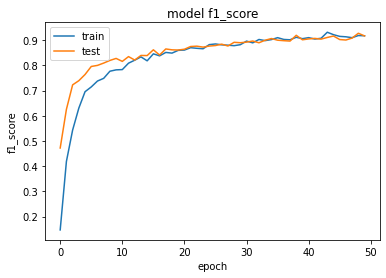

In [31]:
plt.plot(model_history_1.history['f1_score'])
plt.plot(model_history_1.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Modelo 2

In [39]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

dense_layer_256  = Dense(256, activation='relu')
dense_layer_128  = Dense(128, activation='relu')
dense_layer_52   = Dense(52,  activation='relu')

dropout          = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_2 = tf.keras.Sequential([
  base_model,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  dropout,
  dense_layer_256,
  dropout,
  dense_layer_128,
  dropout,
  dense_layer_52,
  dropout,
  global_average_layer,
  prediction_layer
])

In [40]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_2.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_2 = model_2.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

In [ ]:
plt.plot(model_history_2.history['f1_score'])
plt.plot(model_history_2.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
make_predictions(model_2, name_file_submission='modelo_mejorado_2048_512_1024_256_128_52.csv')

In [ ]:
from google.colab import files

files.download("modelo_mejorado_2048_512_1024_256_128_52.csv")

#### Predicciones

In [ ]:
make_predictions(model,  name_file_submission='model_2048_512_1024.csv')

#### Testss

In [29]:
path_test ='/root/.keras/datasets/Test'
name_file_submission = 'submission.csv'

images_test = os.listdir(path_test)
samples_to_predict = []

for img in images_test:
  path_img = os.path.join(path_test, img)
  img = image.load_img(path_img,
                       target_size=(img_width, img_height))
  x = image.img_to_array(img)
  samples_to_predict.append(x)

In [30]:
data = {'id.jpg': images_test, 'label': 0}
data = pd.DataFrame(data)
data.to_csv(name_file_submission, index = False)

In [34]:

os.listdir(path_test, or)

['Cereal_Cropland_100.0_(52.56941042667439_58.7670672348718)_64.57291841506958.jpg',
 'Broadleaf_Cropland_100.0_(48.726058315097426_4.517447900780269)_70.22878527641296.jpg',
 'Swamp_add_86.71897053718567_(25.504967546721446_-80.78082226139112)_0.045838108053430915.jpg',
 'Forest_OEN_86.21791005134583_(58.2237661510363_-98.72988029032646)_0.0.jpg',
 'Moss_and_Lichen_98.5647201538086_(67.82208529879657_-67.9629411353465)_0.0.jpg',
 'Forest_CDB_88.02725672721863_(-14.196256097997633_24.4988544285076)_12.294413149356842.jpg',
 'Marshland_add_90.45522809028625_(71.56482609855215_149.92091574504786)_0.07329427171498537.jpg',
 'Forest_CEN_84.55199003219604_(33.77521737843941_-109.51541291757908)_4.408097267150879.jpg',
 'Forest_CDB_88.02149891853333_(-14.07552252381197_24.659832527421827)_14.16195034980774.jpg',
 'Forest_DEN_99.75037574768066_(58.907923071421735_-124.06380860695157)_0.025971035938709974.jpg',
 'Grassland_100.0_(41.522288388686164_-100.84271783857558)_12.514209747314453.jpg',